<a href="https://colab.research.google.com/github/seemab21/Thesis_Transformer_model/blob/main/Transformer_Model_Activity_Recognition_PD_K-Fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup & Dependencies**

In [16]:
import os
import math
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW

from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Config**

In [17]:
root_dir = '/content/drive/MyDrive/IMU/Annotated_Data'
groups = ['PD']
frame_size = 100
feature_cols = [
    'left acceleration X[g]',
    'left acceleration Y[g]',
    'left acceleration Z[g]',
    'left angular X[dps]',
    'left angular Y[dps]',
    'left angular Z[dps]',
]
label_map = {'HES': 0, 'HER': 1, 'TOF': 2, 'FOF': 3}

# **Warmup Scheduler Function**

In [ ]:
def get_linear_warmup_scheduler(optimizer, warmup_steps):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        return 1.0
    return LambdaLR(optimizer, lr_lambda)


# **Data Loading & Frame Building**

In [18]:
# Function to process a single file
def process_file(filepath):
    # Read the data from the Excel file
    data = pd.read_excel(filepath)


    # Drop rows with NaNs in relevant columns
    data = data.dropna(subset=feature_cols + ['Event- Label level 2- Left Foot'])


    # Map activity labels to numerical values
    data['label'] = data['Event- Label level 2- Left Foot'].map(label_map)

    # Drop rows where label mapping failed (NaN labels)
    data = data.dropna(subset=['label'])
    data['label'] = data['label'].astype(int)

    #### DEBUG ####

    unique_labels = data['label'].unique()
    print(f"Unique labels in file {filepath}: {unique_labels}")
    assert all(label in range(len(label_map)) for label in unique_labels), f"Label out of range in file {filepath}"


    # Extract frames and their majority labels
    frames = []
    labels = []
    for i in range(0, len(data) - frame_size + 1, frame_size):
        segment = data.iloc[i:i + frame_size]
        frame = segment[feature_cols].values.flatten()  # Flatten to 1D array

        label = np.bincount(segment['label']).argmax()  # Majority label in frame
         #### DEBUG ####
        assert 0 <= label < len(label_map), f"Frame label {label} out of range in file {filepath}"


        frames.append(frame)
        labels.append(label)

    return frames, labels


# Function to load data from multiple groups and preprocess it
def load_all_group_data(root_dir, groups):
    all_frames = []
    all_labels = []
    skipped_files_count = 0
    a_frame = {i: [] for i in range(frame_size * len(feature_cols))}  # Initialize for the flattened frames
    a_frame['label'] = []  # For storing labels

    # Loop through each group folder (EL, PD, etc.)
    for group in groups:
        group_path = os.path.join(root_dir, group)

        # Loop through all Excel files in the group folder
        for file_name in os.listdir(group_path):
            if file_name.endswith('.xlsx'):
                filepath = os.path.join(group_path, file_name)

                try:
                    # Process each file to extract frames and labels
                    frames, labels = process_file(filepath)
                    all_frames.extend(frames)
                    all_labels.extend(labels)

                    # Add frames and labels to the dictionary
                    for frame, label in zip(frames, labels):
                        for i, val in enumerate(frame):
                            a_frame[i].append(val)
                        a_frame['label'].append(label)

                except KeyError as e:
                    # Handle missing columns in the file
                    print(f"File skipped due to missing columns: {filepath}")
                    print(f"Missing columns error: {e}")
                    skipped_files_count += 1
                    continue  # Skip to the next file

    # Convert lists to numpy arrays
    all_frames = np.array(all_frames)
    all_labels = np.array(all_labels, dtype=int)

    print(f"Total files skipped due to missing columns: {skipped_files_count}")

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(a_frame)

    return all_frames, all_labels, df



# Function to compute class weights for imbalanced datasets
# def compute_class_weights(labels):
#    label_counts = np.bincount(labels)
#    total = len(labels)

#    # Class weight formula to handle class imbalance
#   weights = [total / (2 * c) if c > 0 else 0 for c in label_counts]

#    return torch.tensor(weights, dtype=torch.float32)

def compute_class_weights(labels, num_classes):
    classes = np.arange(num_classes)
    w = compute_class_weight(class_weight='balanced',
                             classes=classes,
                             y=labels)
    return torch.tensor(w, dtype=torch.float32)

# **Dataset & DataLoader**

In [19]:
class IMUDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x, dtype=torch.float32).reshape(-1, 100, 6)
        self.Y = torch.tensor(y, dtype=torch.long).squeeze()

    def __len__(self):
      return len(self.Y)
    def __getitem__(self, idx):
      return self.X[idx], self.Y[idx]


# **Transformer Model**

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.3, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, drop_prob=0.3):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # Multi-head self-attention with residual and norm
        _x = x
        x = self.attn(x)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # Feed-forward network with residual and norm
        _x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + _x)

        return x


class Encoder(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, n_layers, drop_prob=0.3):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, ffn_hidden, drop_prob=drop_prob)
            for _ in range(n_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x



In [ ]:
###### ORIGINAL


class ClassificationHead(nn.Module):
    def __init__(self,d_model, seq_len , n_classes = 4):

      super().__init__()
      self.norm = nn.LayerNorm(d_model)
      self.seq = nn.Sequential( nn.Flatten() , nn.Linear(d_model * seq_len , 512),
                               nn.ReLU(),nn.Linear(512, 256),
                               nn.ReLU(),nn.Linear(256, 128),
                                nn.ReLU(),nn.Linear(128, n_classes)
                                )

    def forward(self,x):
      x = self.norm(x)
      x = self.seq(x)
      return x

In [21]:
class ClassificationHead(nn.Module):
    def __init__(self, d_model, seq_len, n_classes=4, drop_prob=0.3):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * seq_len, 512),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),      # Added dropout
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),      # Added dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),      # Added dropout
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.norm(x)
        x = self.seq(x)
        return x


In [22]:
class TransformerModel(nn.Module):
    def __init__(self, d_model=128, n_head=4, n_layers=4, seq_len=100, hidden=128, num_classes=4, drop_prob=0.3):
        super().__init__()

        # Input projection layer
        self.input_proj = nn.Linear(6, d_model)

        # Positional encoding layer
        self.pos_enc = PositionalEncoding(d_model)

        # Encoder: Adding dropout to each EncoderLayer
        self.encoder = nn.Sequential(*[
            EncoderLayer(d_model, n_head, hidden, drop_prob) for _ in range(n_layers)
        ])

        self.classifier = ClassificationHead(
            d_model=d_model, seq_len=seq_len, n_classes=num_classes
        )

    def forward(self, x):
        # Project input to d_model
        x = self.input_proj(x)

        # Apply positional encoding
        x = self.pos_enc(x)

        # Pass through the encoder layers
        x = self.encoder(x)

        # Pass through the classifier
        return self.classifier(x)


class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        # Compute scaled dot-product attention
        d_k = q.size(-1)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        attn = self.softmax(scores)

        return torch.matmul(attn, v), attn



class LayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))

        self.eps = 1e-6


    def forward(self, x):
        # Normalize across the last dimension
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim, drop_prob=0.3):
        super().__init__()

        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(hidden_dim, d_model)
        )

    def forward(self, x):
        return self.ffn(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()

        self.n_head = n_head
        self.attn = ScaleDotProductAttention()

        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.shape

        qkv = self.qkv_proj(x).reshape(B, T, self.n_head, -1).permute(2, 0, 1, 3)
        q, k, v = torch.chunk(qkv, 3, dim=-1)

        out, _ = self.attn(q, k, v)
        out = out.permute(1, 2, 0, 3).reshape(B, T, C)

        return self.out_proj(out)

# **Training & Evaluation**

In [23]:
def calc_loss(outputs, targets, class_weights, metrics):
    loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
    loss = loss_fn(outputs, targets)

    metrics['loss'].append(loss.item())
    _, preds = torch.max(outputs, 1)
    metrics['correct'] += (preds == targets).sum().item()
    metrics['total'] += targets.size(0)

    return loss



def train_model(model, dataloaders, optimizer, weights, epochs, patience, scheduler=None, scheduler_step_per_batch=False):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train': [], 'val': []}
    epochs_no_improve = 0
    stop_training = False

    # Initialize the learning rate scheduler
    # scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            metrics = {'loss': [], 'correct': 0, 'total': 0}

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out = model(inputs)
                    loss = calc_loss(out, labels, weights, metrics)
                    if phase == 'train':
                      loss.backward();
                      optimizer.step()
                      if scheduler and scheduler_step_per_batch:
                          scheduler.step()

            epoch_loss = np.mean(metrics['loss'])
            epoch_acc = 100 * metrics['correct'] / metrics['total']
            history[phase].append((epoch_loss, epoch_acc))

            # Save model if it improves on validation loss
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(" Best model updated!")
                else:
                    epochs_no_improve += 1

                # Step the scheduler with the validation loss after each epoch
                # if scheduler:
                #    scheduler.step(epoch_loss)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs!")
                stop_training = True
                break

        if stop_training:
            break


    model.load_state_dict(best_model_wts)
    return model, history

def plot_metrics(history):
    epochs = range(1, len(history['train']) + 1)
    train_loss, train_acc = zip(*history['train'])
    val_loss, val_acc = zip(*history['val'])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, val_loss, label='Val')
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train')
    plt.plot(epochs, val_acc, label='Val')
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()

def evaluate_model(model, dataloader, save_path=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute performance metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\nFinal Validation Metrics:")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")
    print(f"F1 Score : {f1 * 100:.2f}%")


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to: {save_path}")
    plt.show()

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

In [30]:
def cross_validate_model(frames, labels, num_classes, batch_size, epochs, patience, learning_rate, root_dir, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(frames, labels), 1):
        print(f"\n--- Fold {fold} / {k} ---")

        x_train, y_train = frames[train_idx], labels[train_idx]
        x_val, y_val = frames[val_idx], labels[val_idx]

        dataloaders = {
            'train': DataLoader(IMUDataset(x_train, y_train), batch_size=batch_size, shuffle=True),
            'val': DataLoader(IMUDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
        }

        model = TransformerModel().to(device)
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        warmup_steps = 200
        scheduler = get_linear_warmup_scheduler(optimizer, warmup_steps=warmup_steps)



        class_weights = compute_class_weights(y_train, num_classes)

        trained_model, history = train_model(model, dataloaders, optimizer, class_weights, epochs, patience, scheduler=scheduler, scheduler_step_per_batch=True)
        plot_metrics(history)

        metrics = evaluate_model(trained_model, dataloaders['val'], save_path=f"{save_dir}/confusion_matrix_fold{fold}.png")
        metrics['fold'] = fold  # Add fold number to metrics dict
        fold_metrics.append(metrics)

        torch.save(trained_model.state_dict(), f"{save_dir}/transformer_fold{fold}.pth")

    # Save all fold metrics to CSV
    df_metrics = pd.DataFrame(fold_metrics)
    csv_path = f"{save_dir}/cross_validation_metrics.csv"
    df_metrics.to_csv(csv_path, index=False)
    print(f"\nSaved cross-validation metrics to {csv_path}")

    # Print average metrics
    avg_acc = df_metrics['accuracy'].mean()
    avg_prec = df_metrics['precision'].mean()
    avg_rec = df_metrics['recall'].mean()
    avg_f1 = df_metrics['f1'].mean()

    print(f"\nAverage metrics over {k} folds:")
    print(f"Accuracy : {avg_acc:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall   : {avg_rec:.4f}")
    print(f"F1 Score : {avg_f1:.4f}")

    return fold_metrics


**Warmup_steps Calculation**

1285 samples total

batch size is 16

**batches per epoch: 81**

For 2 epochs warmup: warmup_steps = 81 × 2 = **162**

For 3 epochs warmup: warmup_steps = 81×3 = **243**

Set warmup_steps somewhere between **150** to **250**

**Warmup_steps = 200**

In [31]:
# Hyperparameters
num_classes = 4
learning_rate = 1e-06
batch_size = 16
epochs = 100
patience = 15

# **Run Everything**

In [32]:
frames, labels, df = load_all_group_data(root_dir, groups)

Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_1slow2.xlsx: [3 1 2 0]
Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_1slow1.xlsx: [3 1 2 0]
Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd002_1norm2.xlsx: [3 1 2 0]
Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_1norm1.xlsx: [3 1 2 0]
Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd002_1slow1.xlsx: [3 0 1 2]
Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_2tug1.xlsx: [3 0 1 2]
Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_1high1.xlsx: [3 1 0 2]
Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd002_1norm1.xlsx: [3 1 2 0]
Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_2tug2.xlsx: [3 0 1 2]
Unique labels in file /content/drive/MyDrive/IMU/Annotated_Data/PD/pd002_1high1.xlsx: [3 2 0 1]
Unique labels in file /content/drive/MyDri

Unique labels in dataset: [0 1 2 3]
Counts per label: [247  87 451 500]


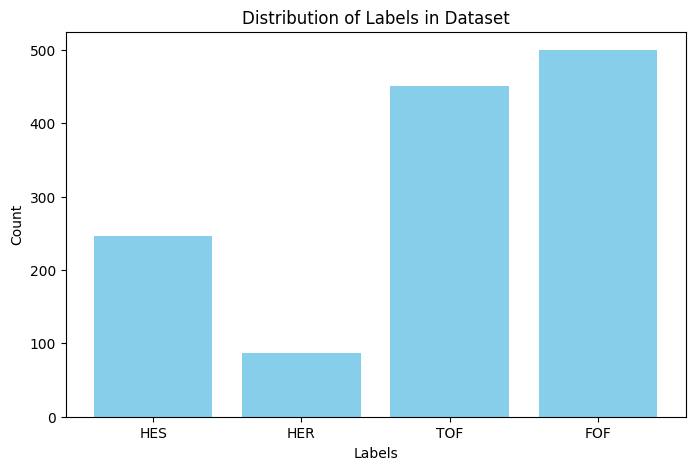

In [33]:
#### DEBUG ####
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Unique labels in dataset: {unique_labels}")
print(f"Counts per label: {counts}")

assert np.all((labels >= 0) & (labels < len(label_map))), "Some labels are out of expected range!"

# Map numeric labels back to their string names for plotting
label_names = list(label_map.keys())

plt.figure(figsize=(8,5))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in Dataset')
plt.show()

In [34]:
# Apply global normalization across all frames
scaler = StandardScaler()
frames = scaler.fit_transform(frames)

# Class weights
class_weights = compute_class_weights(labels, num_classes)


In [35]:
print(f"Data shape (frames): {frames.shape}")  # e.g., (num_samples, frame_size*features)
print(f"Labels distribution: {np.bincount(labels)}")
print(f"Unique labels: {np.unique(labels)}")
print(f"Unique labels and counts: {np.unique(labels, return_counts=True)}")

print(f"Sample features (first frame, first 10 values): {frames[0][:10]}")

print(f"Class weights: {class_weights.numpy()}")

Data shape (frames): (1285, 600)
Labels distribution: [247  87 451 500]
Unique labels: [0 1 2 3]
Unique labels and counts: (array([0, 1, 2, 3]), array([247,  87, 451, 500]))
Sample features (first frame, first 10 values): [ 0.19134057 -0.14148891 -0.19264917  0.00380857 -0.0202356   0.10912425
  0.17930963 -0.18209751 -0.17661243  0.01267476]
Class weights: [1.3006073  3.6925287  0.71230596 0.6425    ]


**label mapping** {'HES': 0, 'HER': 1, 'TOF': 2, 'FOF': 3}


--- Fold 1 / 5 ---

Epoch 1/100
------------------------------
Train Loss: 1.3864 | Accuracy: 19.07%
 Best model updated!
Val Loss: 1.3883 | Accuracy: 23.35%

Epoch 2/100
------------------------------
Train Loss: 1.3871 | Accuracy: 23.93%
 Best model updated!
Val Loss: 1.3847 | Accuracy: 38.13%

Epoch 3/100
------------------------------
Train Loss: 1.3842 | Accuracy: 25.49%
 Best model updated!
Val Loss: 1.3821 | Accuracy: 38.91%

Epoch 4/100
------------------------------
Train Loss: 1.3884 | Accuracy: 25.88%
 Best model updated!
Val Loss: 1.3796 | Accuracy: 38.91%

Epoch 5/100
------------------------------
Train Loss: 1.3831 | Accuracy: 28.11%
 Best model updated!
Val Loss: 1.3774 | Accuracy: 38.91%

Epoch 6/100
------------------------------
Train Loss: 1.3824 | Accuracy: 30.16%
 Best model updated!
Val Loss: 1.3754 | Accuracy: 38.91%

Epoch 7/100
------------------------------
Train Loss: 1.3800 | Accuracy: 31.52%
 Best model updated!
Val Loss: 1.3736 | Accuracy: 38.91%

Epoch 

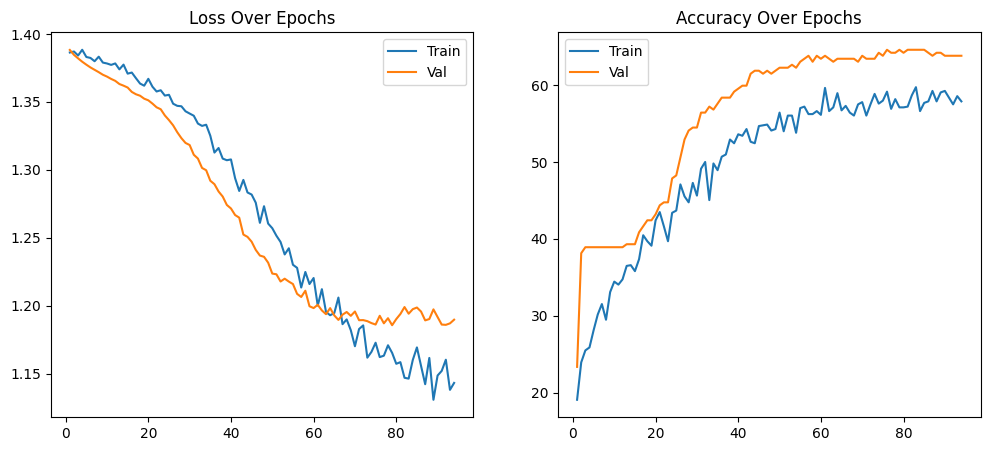


Final Validation Metrics:
Accuracy : 64.59%
Precision: 63.85%
Recall   : 64.59%
F1 Score : 59.67%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold1.png


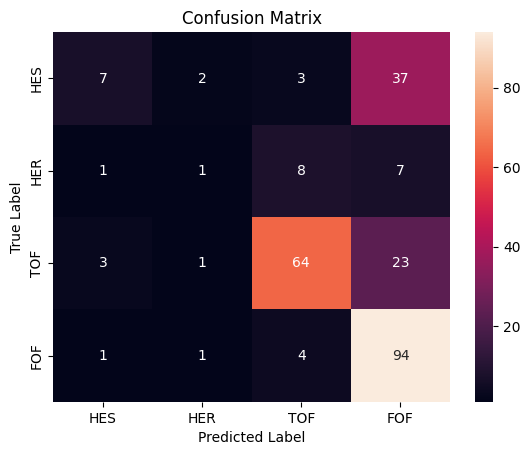


--- Fold 2 / 5 ---

Epoch 1/100
------------------------------
Train Loss: 1.3883 | Accuracy: 34.82%
 Best model updated!
Val Loss: 1.3828 | Accuracy: 38.91%

Epoch 2/100
------------------------------
Train Loss: 1.3845 | Accuracy: 35.70%
 Best model updated!
Val Loss: 1.3804 | Accuracy: 38.91%

Epoch 3/100
------------------------------
Train Loss: 1.3818 | Accuracy: 37.74%
 Best model updated!
Val Loss: 1.3777 | Accuracy: 38.91%

Epoch 4/100
------------------------------
Train Loss: 1.3844 | Accuracy: 36.38%
 Best model updated!
Val Loss: 1.3763 | Accuracy: 38.91%

Epoch 5/100
------------------------------
Train Loss: 1.3862 | Accuracy: 35.99%
 Best model updated!
Val Loss: 1.3743 | Accuracy: 38.91%

Epoch 6/100
------------------------------
Train Loss: 1.3769 | Accuracy: 38.23%
 Best model updated!
Val Loss: 1.3719 | Accuracy: 38.91%

Epoch 7/100
------------------------------
Train Loss: 1.3817 | Accuracy: 36.48%
 Best model updated!
Val Loss: 1.3703 | Accuracy: 38.91%

Epoch 

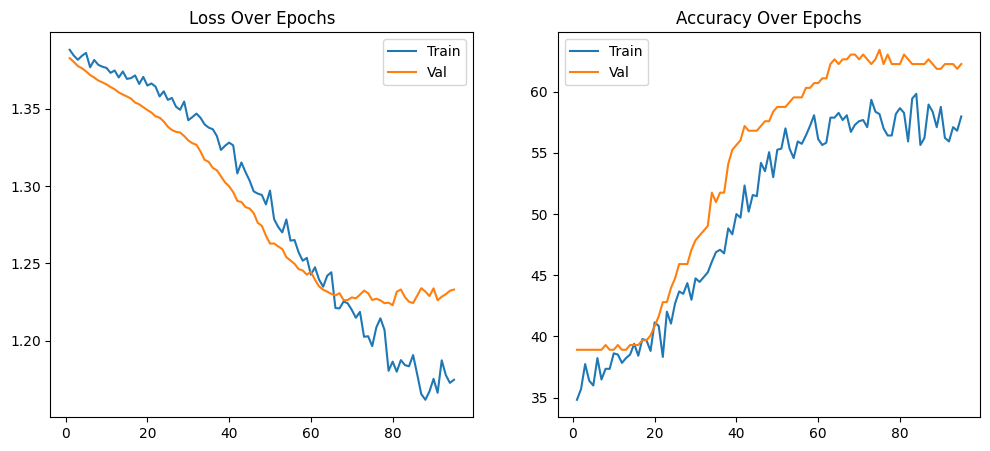


Final Validation Metrics:
Accuracy : 62.26%
Precision: 57.45%
Recall   : 62.26%
F1 Score : 56.64%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold2.png


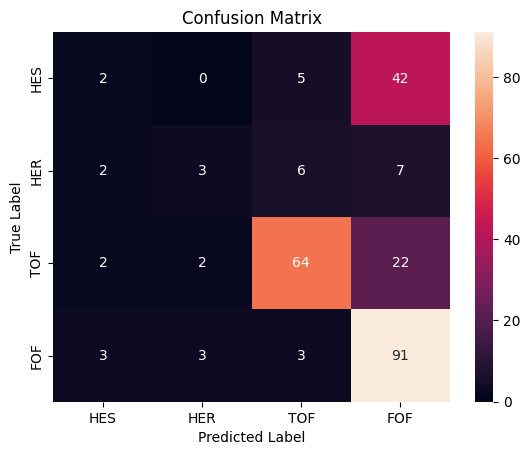


--- Fold 3 / 5 ---

Epoch 1/100
------------------------------
Train Loss: 1.3840 | Accuracy: 33.95%
 Best model updated!
Val Loss: 1.3782 | Accuracy: 35.80%

Epoch 2/100
------------------------------
Train Loss: 1.3840 | Accuracy: 35.21%
 Best model updated!
Val Loss: 1.3740 | Accuracy: 54.09%

Epoch 3/100
------------------------------
Train Loss: 1.3792 | Accuracy: 39.30%
 Best model updated!
Val Loss: 1.3692 | Accuracy: 45.91%

Epoch 4/100
------------------------------
Train Loss: 1.3794 | Accuracy: 39.11%
 Best model updated!
Val Loss: 1.3640 | Accuracy: 43.19%

Epoch 5/100
------------------------------
Train Loss: 1.3790 | Accuracy: 40.95%
 Best model updated!
Val Loss: 1.3605 | Accuracy: 41.63%

Epoch 6/100
------------------------------
Train Loss: 1.3750 | Accuracy: 40.86%
 Best model updated!
Val Loss: 1.3567 | Accuracy: 40.86%

Epoch 7/100
------------------------------
Train Loss: 1.3757 | Accuracy: 41.93%
 Best model updated!
Val Loss: 1.3544 | Accuracy: 39.69%

Epoch 

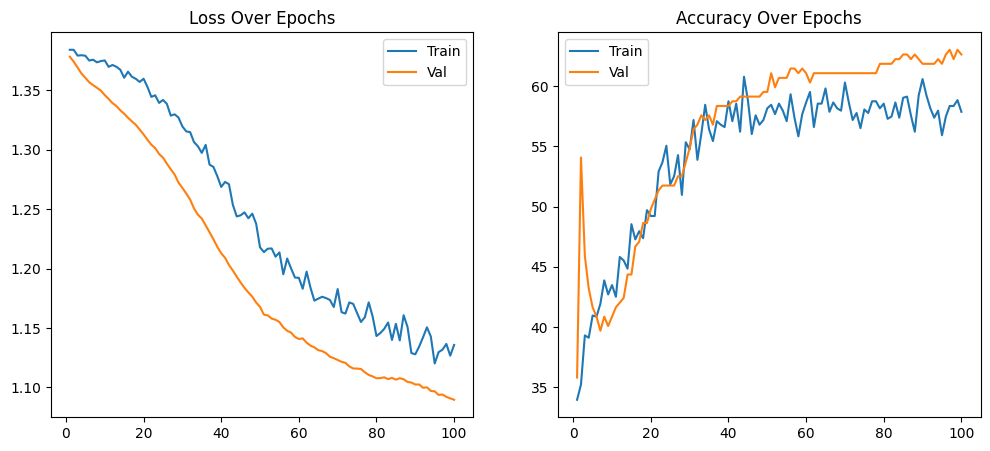


Final Validation Metrics:
Accuracy : 62.65%
Precision: 58.91%
Recall   : 62.65%
F1 Score : 57.90%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold3.png


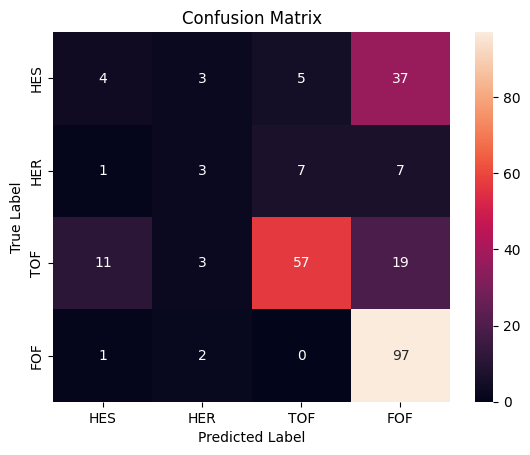


--- Fold 4 / 5 ---

Epoch 1/100
------------------------------
Train Loss: 1.3865 | Accuracy: 21.30%
 Best model updated!
Val Loss: 1.3897 | Accuracy: 19.46%

Epoch 2/100
------------------------------
Train Loss: 1.3874 | Accuracy: 22.47%
 Best model updated!
Val Loss: 1.3846 | Accuracy: 19.46%

Epoch 3/100
------------------------------
Train Loss: 1.3838 | Accuracy: 22.37%
 Best model updated!
Val Loss: 1.3813 | Accuracy: 19.46%

Epoch 4/100
------------------------------
Train Loss: 1.3815 | Accuracy: 23.93%
 Best model updated!
Val Loss: 1.3781 | Accuracy: 19.84%

Epoch 5/100
------------------------------
Train Loss: 1.3827 | Accuracy: 26.36%
 Best model updated!
Val Loss: 1.3754 | Accuracy: 25.68%

Epoch 6/100
------------------------------
Train Loss: 1.3835 | Accuracy: 23.74%
 Best model updated!
Val Loss: 1.3725 | Accuracy: 29.57%

Epoch 7/100
------------------------------
Train Loss: 1.3822 | Accuracy: 27.72%
 Best model updated!
Val Loss: 1.3697 | Accuracy: 34.63%

Epoch 

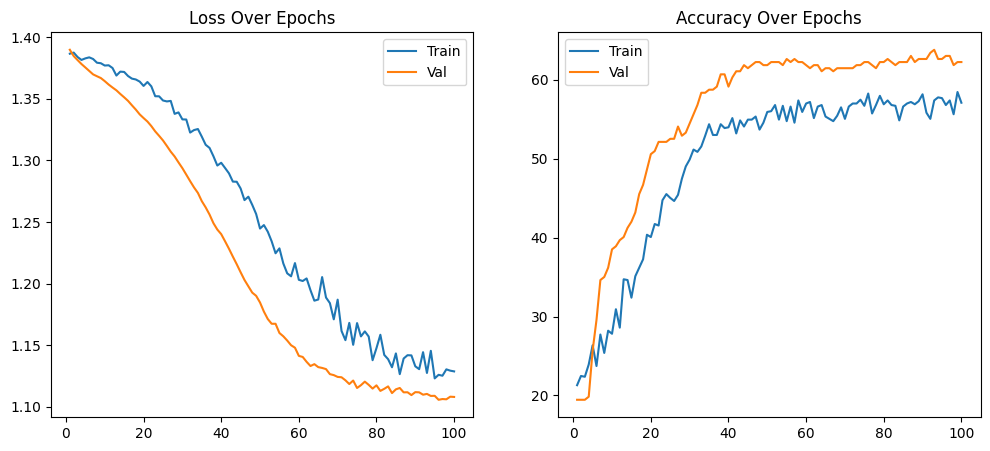


Final Validation Metrics:
Accuracy : 63.04%
Precision: 53.96%
Recall   : 63.04%
F1 Score : 56.58%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold4.png


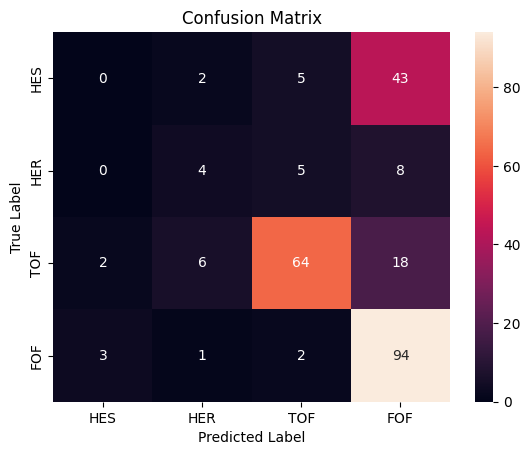


--- Fold 5 / 5 ---

Epoch 1/100
------------------------------
Train Loss: 1.3853 | Accuracy: 20.72%
 Best model updated!
Val Loss: 1.3849 | Accuracy: 19.46%

Epoch 2/100
------------------------------
Train Loss: 1.3857 | Accuracy: 19.65%
 Best model updated!
Val Loss: 1.3831 | Accuracy: 19.46%

Epoch 3/100
------------------------------
Train Loss: 1.3861 | Accuracy: 21.30%
 Best model updated!
Val Loss: 1.3804 | Accuracy: 19.46%

Epoch 4/100
------------------------------
Train Loss: 1.3865 | Accuracy: 21.98%
 Best model updated!
Val Loss: 1.3788 | Accuracy: 19.84%

Epoch 5/100
------------------------------
Train Loss: 1.3852 | Accuracy: 22.08%
 Best model updated!
Val Loss: 1.3765 | Accuracy: 20.62%

Epoch 6/100
------------------------------
Train Loss: 1.3830 | Accuracy: 21.01%
 Best model updated!
Val Loss: 1.3757 | Accuracy: 21.79%

Epoch 7/100
------------------------------
Train Loss: 1.3820 | Accuracy: 23.93%
 Best model updated!
Val Loss: 1.3732 | Accuracy: 25.29%

Epoch 

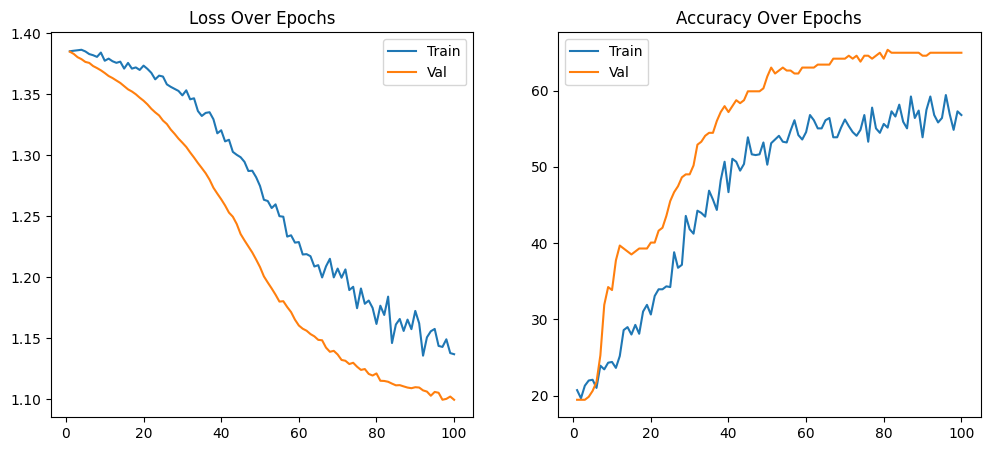


Final Validation Metrics:
Accuracy : 64.98%
Precision: 54.33%
Recall   : 64.98%
F1 Score : 57.28%
Confusion matrix saved to: /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/confusion_matrix_fold5.png


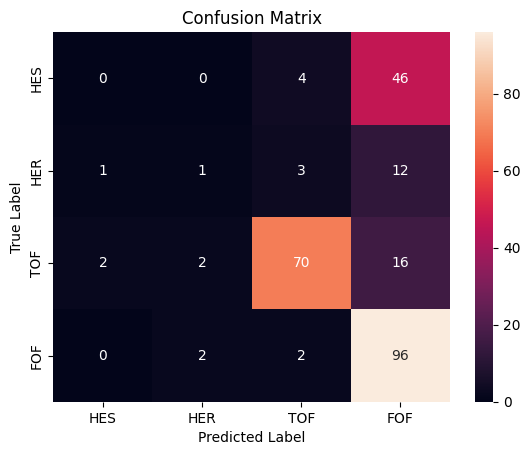


Saved cross-validation metrics to /content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD/cross_validation_metrics.csv

Average metrics over 5 folds:
Accuracy : 0.6350
Precision: 0.5770
Recall   : 0.6350
F1 Score : 0.5761


In [36]:
save_dir = '/content/drive/MyDrive/IMU/kFold_Activity_Recognition_PD'

fold_metrics = cross_validate_model(
    frames=frames,
    labels=labels,
    num_classes=num_classes,
    batch_size=batch_size,
    epochs=epochs,
    patience=patience,
    learning_rate=learning_rate,
    root_dir=save_dir,
    k=5
)